En este ejercicio, abordaremos el problema de predicción de temperatura usando la base de datos de la Estación Meteorológica del Instituto Max-Planck de Biogeoquímica en Jena, Alemania: http://www.bgc-jena.mpg.de/wetter/. <br>
Esta base de datos representa una serie de tiempo, en la que 14 cantidades diferentes (incluyendo temperatura del aire, presión atmosférica, humedad y dirección del viento) fueron registradas cada 10 minutos, a lo largo de varios años. 
Específicamente, estaremos trabajando con una base de datos integrada por registros que abarcan el período de 2009-2016.
En la terminología de las series de tiempo, cada uno de los registros de este tipo de base de datos, se denomina ***timestep***.

In [1]:
# Descargar base de datos
!cd ~/Downloads
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

/bin/bash: line 0: cd: /root/Downloads: No such file or directory
--2021-08-13 12:59:03--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.139.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.139.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  42.5MB/s    in 0.3s    

2021-08-13 12:59:04 (42.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Analicemos los datos:

In [2]:
import os

fname = '/content/jena_climate_2009_2016.csv'  # Ubicamos la DB
f = open(fname)                                # Abrimos el archivo
data = f.read()                                # Leemos el archivo, guardandolo
f.close()                                      # Cerramos el archivo

lines = data.split('\n')                       # Particiona la lista de texto por salto de linea
header = lines[0].split(',')                   # Se toma el nombre de cada columna ya que la primera linea son los encabezados
lines = lines[1:]                              # Las lineas se toman desde el indice uno, teniendo los registros, sin el encabezado

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Convertimos las líneas de texto en un numpy array:

In [3]:
# Keras no recibe listas, unicamente numpy arrays o tensores
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))   # Limitando las orillas
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]  # Ir poniendo cada valor en cada fila, ya en punto flotante
    float_data[i, :] = values

Graficamos la temperatura a lo largo del tiempo:

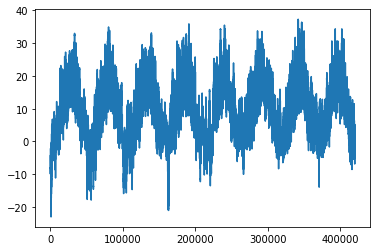

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

Graficamos los valores de temperatura en los primeros 10 días.<br>
Para ello, consideremos que, si los registros del clima se realizan cada 10 minutos, quiere decir que en una hora, se tienen 6 registros, consecuentemente, en un día, se tendrán 24 x 6 = 144 registros. Por lo tanto, en 10 días, se habrán registrado 144 x 10 = 1440 datos sobre el clima.

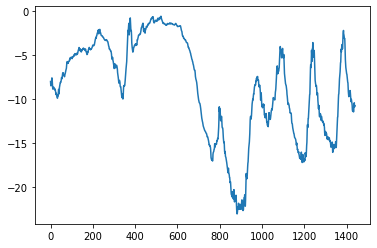

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

# **Normalización de los datos**

In [6]:
# Tener los datos en un rango similar para facilitar el proceso
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# **Construcción de un generador de datos**

Nuestro generador de datos, va a generar la tupla (muestras, etiquetas), donde las muestras representan un lote de registros climáticos, por ejemplo, si el tamaño del lote es de 128, quiere decir que el generador va a producir 128 registros (muestras) climáticos, y ante cada una de las 128 muestras, se tendrá su respectiva etiqueta.<br>
Técnicamente, el generador es una función que toma los siguientes argumentos:<br>
data: The original array of floating point data, 

*   data: Es el arreglo original de los datos, el cual fue normalizado previamente.
*   lookback: Cuántos timesteps del pasado deben considerarse para constituir los datos de entrada.
*   delay: Cuántos timesteps posteriores deben contemplarse para conformar las etiquetas.
*   min_index y max_index: Estos índices permiten delimitar los timesteps que se van a usar. Además, son útiles para realizar la partición de los datos en conjuntos de validación y prueba.
*   shuffle: Permite determinar si las muestras se tomarán en orden cronológico o de forma aleatoria.
*   batch_size:  Número de muestras por lote.
*   step:  El período, en timesteps, en que se realizará el muestro de datos. En este caso, su valor será 6 con la intención de muestrear un dato cada hora.


In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)   # Se genera un lote de 128 valores entre 1440-200000
        else:                                                       
            if i + batch_size >= max_index:                          
                i = min_index + lookback                            # Se resetea el valor de i
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),          # samples (128, (1440/6), 14)
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))        # targets (128)
        for j, row in enumerate(rows):                            
            indices = range(rows[j] - lookback, rows[j], step)  # range(1440-1440, 1440, 6) --> range(0, 1440, 6)
            samples[j] = data[indices] 
            targets[j] = data[rows[j] + delay][1]               # data[1440 + 144] 
        yield samples, targets

Ahora, usaremos el generador para construir tres generadores, uno para entrenamiento, otro para validación y el restante para prueba. Cada uno de ellos, se conformará por diferentes segmentos temporales de los datos de entrada: el generador de entrenamiento usará los primeros 200,000 datos, el de validación los siguientes 100,000 y el de prueba empleará los restantes.

In [9]:
lookback = 1440      # Se toma la informacion de 10 dias previos, los cuales consisten en 1440 timestep para predecir el futuro 
step = 6             # Permite hacer un muestreo, para cada valor de entrada (1440 timesteps) se hace el muestro cada 6 timesteps reduciendo la carga de datos computacionales. 
delay = 144          # Timestep por dia, 144 --> Pronostico Dia 11, 288 --> Pronostico Dia 12, 432 --> Pronostico Dia 13
batch_size = 128     # Lotes para procesar

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# **Modelo 1: Red neuronal densamente conectada**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 16s 31ms/step - loss: 1.2586 - val_loss: 0.5515
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.4091 - val_loss: 0.3759
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2918 - val_loss: 0.3075
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2660 - val_loss: 0.2987
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2513 - val_loss: 0.3337
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2411 - val_loss: 0.3189
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2367 - val_loss: 0.3117
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2300 - val_loss: 0.3240
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2259 - val_loss: 0.3207
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.221

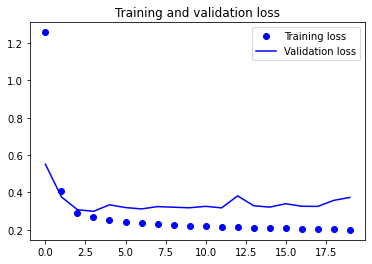

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Modelo 2: Primera arquitectura recurrente**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))  # Los atributos siempre se ponen asi, para un problema de series de tiempo
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 94s 184ms/step - loss: 0.3044 - val_loss: 0.2708
Epoch 2/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2832 - val_loss: 0.2690
Epoch 3/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2775 - val_loss: 0.2659
Epoch 4/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2714 - val_loss: 0.2640
Epoch 5/20
500/500 [==============================] - 92s 183ms/step - loss: 0.2685 - val_loss: 0.2649
Epoch 6/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2637 - val_loss: 0.2629
Epoch 7/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2597 - val_loss: 0.2647
Epoch 8/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2571 - val_loss: 0.2653
Epoch 9/20
500/500 [==============================] - 92s 183ms/step - loss: 0.2523 - val_loss: 0.2782
Epoch 10/20
500/500 [==============================] - 92s 184ms/step - l

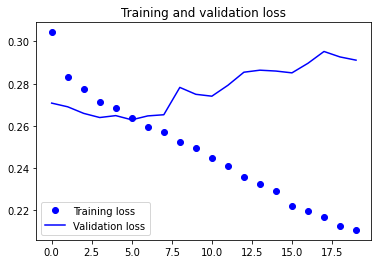

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Modelo 3: Recurrent dropout**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,              # Anula de forma aleatoria ciertas neuronas, anula los pesos.  Se aplica para la salida de la GRU
                     recurrent_dropout=0.2,    # Anula el 20% de todas las neuronas del modelo recurrente
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 151s 299ms/step - loss: 0.3261 - val_loss: 0.2763
Epoch 2/40
500/500 [==============================] - 150s 300ms/step - loss: 0.3063 - val_loss: 0.2728
Epoch 3/40
500/500 [==============================] - 149s 298ms/step - loss: 0.2986 - val_loss: 0.2763
Epoch 4/40
500/500 [==============================] - 149s 298ms/step - loss: 0.2934 - val_loss: 0.2696
Epoch 5/40
500/500 [==============================] - 149s 298ms/step - loss: 0.2907 - val_loss: 0.2722
Epoch 6/40
500/500 [==============================] - 149s 298ms/step - loss: 0.2840 - val_loss: 0.2667
Epoch 7/40
500/500 [==============================] - 149s 297ms/step - loss: 0.2804 - val_loss: 0.2670
Epoch 8/40
500/500 [==============================] - 154s 307ms/step - loss: 0.2773 - val_loss: 0.2704
Epoch 9/40
500/500 [==============================] - 149s 298ms/step - loss: 0.2749 - val_loss: 0.2705
Epoch 10/40
500/500 [==============================] - 148s 297m

KeyboardInterrupt: ignored

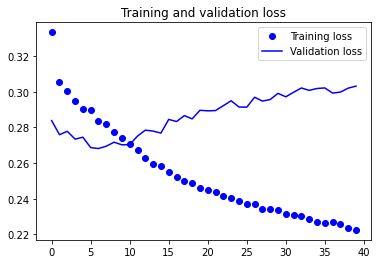

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Modelo 4: Redes neuronales recurrentes profundas**

In [ ]:
# Apilar varias capas recurrentes
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,                       # Si se tienen varias capas recurrentes, en la ultima capa se debe poner return_sequences=False
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 451s 891ms/step - loss: 0.3218 - val_loss: 0.2848
Epoch 2/40
500/500 [==============================] - 445s 890ms/step - loss: 0.3000 - val_loss: 0.2901
Epoch 3/40
500/500 [==============================] - 439s 878ms/step - loss: 0.2946 - val_loss: 0.2764
Epoch 4/40
500/500 [==============================] - 438s 877ms/step - loss: 0.2888 - val_loss: 0.2728
Epoch 5/40
500/500 [==============================] - 440s 880ms/step - loss: 0.2810 - val_loss: 0.2683
Epoch 6/40
500/500 [==============================] - ETA: 0s - loss: 0.2746

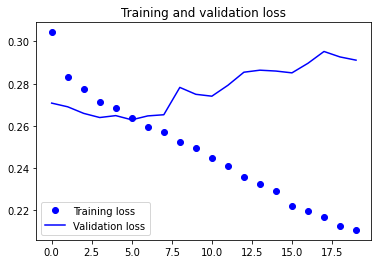

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Las diversas implementaciones presentadas en este notebook, fueron tomadas de https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
Agradecemos a François Chollet por su amabilidad es hacer públicos sus códigos e implementaciones.